# Plan of Action

**Our age prediction CNN model shall be defined and trained by**:
1. Importing **training and test datasets** from Google Drive Input Sub-folder
2. **Training dataset is already augmented** and has 234,000 images
3. **Greyscaling images** instead of using RGB color images
4. Defining our intuitively **distributed classes of age-ranges**
5. Using **60 epochs** on our **optimized CNN Architecture**, comprising of:
    - an input *Conv2D* layer (with 32 filters) paired with an *AveragePooling2D* layer,
    - 3 pairs of *Conv2D* (with 64, 128 & 256 filters) and *AveragePooling2D* layers,
    - a *GlobalAveragePooling2D* layer,
    - 1 *Dense* layer with 132 nodes, and
    - an output *Dense* layer with 7 nodes.

# Mount Google Drive & Imports

In [1]:
#@title Mount Google Drive {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torchvision import datasets, transforms

import tensorflow as tf

# Setting random seeds to reduce the amount of randomness in the neural net weights and results
# The results may still not be exactly reproducible

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
#@title Check for GPU

# Testing to ensure GPU is being utilized
# Ensure that the Runtime Type for this notebook is set to GPU
# If a GPU device is not found, change the runtime type under: Runtime>> Change runtime type>> Hardware accelerator>> GPU
# and run the notebook from the beginning again.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Data Preparation

## Import Dataset

In [4]:
'''# Unzipping the dataset file combined_faces.zip
input_path = "/content/drive/MyDrive/DeepLearning_2023/Final Project/Data/"
combined_faces_zip_path = input_path+'crop_part1.tar.gz'

import tarfile
import gzip

# Open the tar.gz file for reading
with tarfile.open(combined_faces_zip_path, 'r:gz') as tar:
    # Extract all files to a specified directory
    tar.extractall(input_path)'''

'# Unzipping the dataset file combined_faces.zip\ninput_path = "/content/drive/MyDrive/DeepLearning_2023/Final Project/Data/"\ncombined_faces_zip_path = input_path+\'crop_part1.tar.gz\'\n\nimport tarfile\nimport gzip\n\n# Open the tar.gz file for reading\nwith tarfile.open(combined_faces_zip_path, \'r:gz\') as tar:\n    # Extract all files to a specified directory\n    tar.extractall(input_path)'

In [5]:
'''# Unzipping the dataset file combined_faces.zip
input_path = "/content/drive/MyDrive/DeepLearning_2023/Final Project/Data/"
combined_faces_zip_path_2 = input_path+'UTKFace.tar.gz'

# Open the tar.gz file for reading
with tarfile.open(combined_faces_zip_path_2, 'r:gz') as tar:
    # Extract all files to a specified directory
    tar.extractall(input_path)'''

'# Unzipping the dataset file combined_faces.zip\ninput_path = "/content/drive/MyDrive/DeepLearning_2023/Final Project/Data/"\ncombined_faces_zip_path_2 = input_path+\'UTKFace.tar.gz\'\n\n# Open the tar.gz file for reading\nwith tarfile.open(combined_faces_zip_path_2, \'r:gz\') as tar:\n    # Extract all files to a specified directory\n    tar.extractall(input_path)'

In [6]:
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

In [7]:
input_path = "/content/drive/MyDrive/DeepLearning_2023/Final Project/Data/"
# List all files in the folder
files = os.listdir(input_path+'UTKFace/')

# Initialize an empty list to store the image paths
image_paths = []
labels =[]
genderlist=[]
racelist = []
# Iterate over the files in the folder

for file in files:
  # Check if the file is an image
  if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
    # Construct the full path to the image file
    age = file.split("_")[0]
    gender = file.split("_")[1]
    race = file.split("_")[2]
    image_path = os.path.join(input_path+'UTKFace/', file)

    # Append the image path to the list
    image_paths.append(image_path)
    labels.append(age)
    genderlist.append(gender)
    racelist.append(race)

# Create a DataFrame with the image paths
df = pd.DataFrame({'image_path': image_paths,"age":labels,"gender":gender,"race":race})
df = df.astype({'age':int})

In [8]:
display(df)

,image_path,age,gender,race
0,/content/drive/MyDrive/DeepLearning_2023/Final...,56,0,2
1,/content/drive/MyDrive/DeepLearning_2023/Final...,56,0,2
2,/content/drive/MyDrive/DeepLearning_2023/Final...,56,0,2
3,/content/drive/MyDrive/DeepLearning_2023/Final...,56,0,2
4,/content/drive/MyDrive/DeepLearning_2023/Final...,56,0,2
...,...,...,...,...
23703,/content/drive/MyDrive/DeepLearning_2023/Final...,1,0,2
23704,/content/drive/MyDrive/DeepLearning_2023/Final...,1,0,2
23705,/content/drive/MyDrive/DeepLearning_2023/Final...,1,0,2
23706,/content/drive/MyDrive/DeepLearning_2023/Final...,1,0,2


## Know your Dataset

<Axes: >

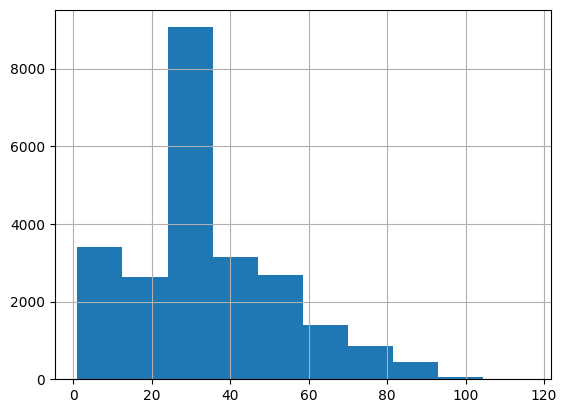

In [9]:
df['age'].hist()

In [10]:

df['age'].describe()

count    23708.000000
mean        33.303484
std         19.886112
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

In [11]:

import plotly.express as px
fig = px.histogram(df, x="age", nbins=20)
fig.update_layout(title_text='Age distribution')
fig.show()


In [12]:

import plotly.graph_objects as go
def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()

    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)

    fig.show()

In [13]:
df.shape

(23708, 4)

## Define Age Classes

In [14]:
# Defining a function to return the class labels corresponding to the re-distributed 7 age-ranges.

def class_labels_reassign(age):

    if 1 <= age <= 10:
        return 0
    elif 11 <= age <= 20:
        return 1
    elif 21 <= age <= 30:
        return 2
    elif 31 <= age <= 40:
        return 3
    elif 41 <= age <= 60:
        return 4
    elif 61 <= age <= 80:
        return 5
    elif 81 <= age:
        return 6

In [15]:
df['target'] = df['age'].map(class_labels_reassign)

In [16]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
age_binned = pd.cut(df['age'], bins, labels=names)
plot_distribution(age_binned)


## Downsampling to manage

In [17]:
df2 = df.copy()

In [18]:
df = df2.copy()

In [19]:
print(df['target'].value_counts(),"\n")
#downsampling
df = df.drop(df[df['target'] == 2].sample(frac=.3).index)

2    7784
3    4339
4    4311
0    3218
5    1857
1    1659
6     540
Name: target, dtype: int64 



In [20]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
age_binned = pd.cut(df['age'], bins, labels=names)
plot_distribution(age_binned)

## Divide into Train and Test

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['image_path'], df['target'],test_size = 0.15,random_state = 42, stratify=df['target'])

In [22]:
print(type(x_train))

<class 'pandas.core.series.Series'>


## Dataloader


In [23]:
# Converting the filenames and target class labels into lists for augmented train and test datasets.
train_filenames_list = list(x_train)
train_labels_list = list(y_train)

test_filenames_list = list(x_test)
test_labels_list = list(y_test)

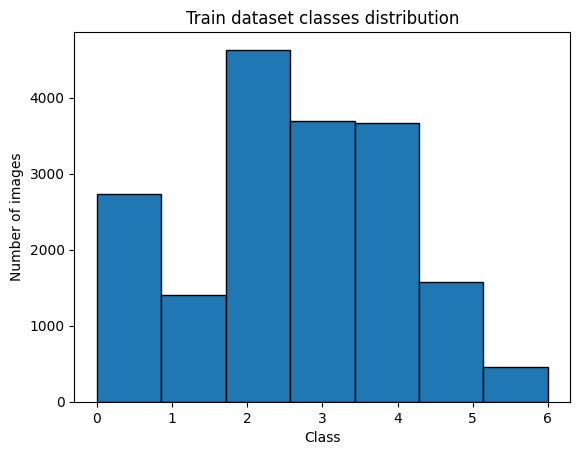

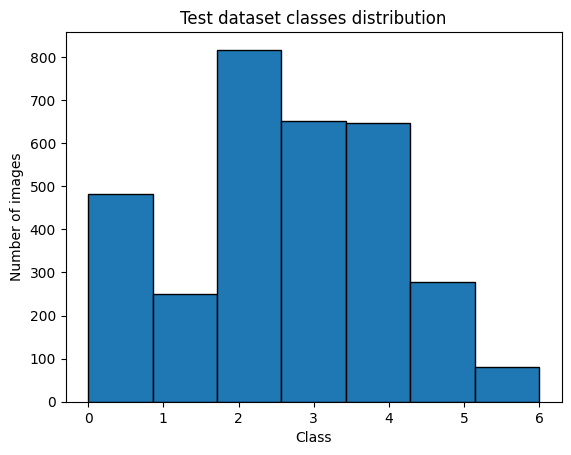

In [24]:
import matplotlib.pyplot as plt

plt.hist(train_labels_list, bins=7, edgecolor='black')  # Plot histogram
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Train dataset classes distribution')
plt.show()

plt.hist(test_labels_list, bins=7, edgecolor='black')  # Plot histogram
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Test dataset classes distribution')
plt.show()

TRAIN DATASET EXAMPLES
Feature batch shape: torch.Size([256, 3, 150, 150])
Labels batch shape: torch.Size([256])


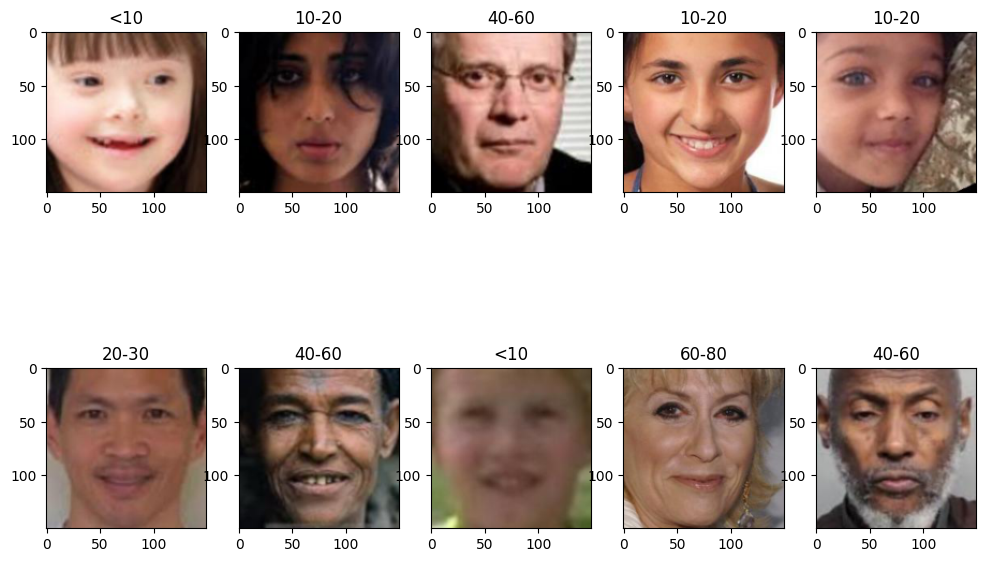

In [25]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio
from google.colab import drive
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]

        image = Image.open(image_path).convert('RGB') #########

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize the image to a specific size
    #transforms.Grayscale(),
    transforms.CenterCrop(150),
    transforms.ToTensor()  # Convert image to tensor
])



class_labels = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
class_labels_map = {}
for idx, label in enumerate(class_labels):
  class_labels_map[str(idx)] = label

# Create the custom dataset
train_dataset = CustomDataset(train_filenames_list, train_labels_list, transform=transform)

# Create the dataloader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False) #PROVAR AUGMENTAR BACTHSIZE

# Create the custom dataset
test_dataset = CustomDataset(test_filenames_list, test_labels_list, transform=transform)

# Create the dataloader
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False) #PROVAR AUGMENTAR BACTHSIZE

print('TRAIN DATASET EXAMPLES')
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
indx = 0
f, axarr = plt.subplots(2, 5, figsize=(12, 8))
for r in range(0, 2):
  for c in range(0, 5):
    img = train_features[indx].squeeze()
    label = train_labels[indx]
    axarr[r, c].imshow(transforms.ToPILImage()(img))
    axarr[r, c].set_title(class_labels_map.get(str(label.item())))
    indx+=1


# CNN Architecture

In [26]:
# results_path = '/content/drive/MyDrive/DeepLearning_2023/Final Project/dl_nmm/1.1_age_input_output/output/'


# #Train function with accumulation steps to try to reduce the running time
# def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu', accumulation_steps=10):
#   CNN.train() # Set the model in train mode
#   total_step = len(train_loader)
#   losses_list = []
#   #['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
#   class_weights = torch.Tensor([1.0, 1.1, 0.8, 1, 1, 1.2, 3]).to(device)

#   # weight=class_weights
#   criterion = nn.CrossEntropyLoss()

#   # Iterate over epochs
#   for epoch in range(num_epochs):
#       loss_avg = 0
#       nBatches = 0
#       accumulation_loss = 0

#       # Iterate over batches
#       for i, (images, labels) in enumerate(train_loader):
#           images = images.to(device)
#           labels = labels.type(torch.LongTensor).to(device)

#           # Forward pass
#           outputs = CNN(images)
#           loss = criterion(outputs, labels)

#           # Backward pass
#           loss.backward()

#           # Accumulate gradients
#           accumulation_loss += loss.item()

#           if (i + 1) % accumulation_steps == 0:
#               optimizer.step()
#               optimizer.zero_grad()
#               loss_avg += accumulation_loss / accumulation_steps
#               accumulation_loss = 0
#               nBatches += 1

#               if (i + 1) % 100 == 0:
#                   print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
#                       epoch + 1, num_epochs, i + 1, total_step, loss_avg / nBatches))

#       # Perform the final update if there are remaining accumulated gradients
#       if accumulation_loss > 0:
#           optimizer.step()
#           optimizer.zero_grad()
#           loss_avg += accumulation_loss / accumulation_steps
#           nBatches += 1

#       print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
#           epoch + 1, num_epochs, i + 1, total_step, loss_avg / nBatches))

#       losses_list.append(loss_avg / nBatches)
#       torch.save(CNN.state_dict(), results_path + '/' + model_name)

#   return losses_list


# # Test funcion
# def test(CNN, test_loader):
#   with torch.no_grad():
#         correct = 0
#         total = 0
#         for images, labels in test_loader:
#             images = images.to(device)
#             labels = labels.to(device)
#             # get network predictions
#             outputs = CNN(images)

#             # get predicted class
#             _, predicted = torch.max(outputs.data, 1)

#             # compare with the ground-truth
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#         # return accuracy
#         return 100 * correct / total

In [27]:
results_path = '/content/drive/MyDrive/DeepLearning_2023/Final Project/dl_nmm/1.1_age_input_output/output/'


#Train function with accumulation steps to try to reduce the running time
def train(CNN, train_loader,test_loader,optimizer, num_epochs=5, model_name='model.ckpt', device='cpu', accumulation_steps=10):
  CNN.train() # Set the model in train mode
  total_step = len(train_loader)
  losses_list = []
  losses_list_test = []
  #['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
  class_weights = torch.Tensor([1.0, 1.1, 0.8, 1, 1, 1.2, 3]).to(device)

  criterion = nn.CrossEntropyLoss(weight=class_weights)

  # Iterate over epochs
  for epoch in range(num_epochs):
      loss_avg = 0
      nBatches = 0
      accumulation_loss = 0

      # Iterate over batches
      for i, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.type(torch.LongTensor).to(device)

          # Forward pass
          outputs = CNN(images)
          loss = criterion(outputs, labels)

          # Backward pass
          loss.backward()

          # Accumulate gradients
          accumulation_loss += loss.item()

          if (i + 1) % accumulation_steps == 0:
              optimizer.step()
              optimizer.zero_grad()
              loss_avg += accumulation_loss / accumulation_steps
              accumulation_loss = 0
              nBatches += 1

              if (i + 1) % 100 == 0:
                  print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                      epoch + 1, num_epochs, i + 1, total_step, loss_avg / nBatches))

      # Perform the final update if there are remaining accumulated gradients
      if accumulation_loss > 0:
          optimizer.step()
          optimizer.zero_grad()
          loss_avg += accumulation_loss / accumulation_steps
          nBatches += 1

      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
          epoch + 1, num_epochs, i + 1, total_step, loss_avg / nBatches))

      # aqui fer el tsting
      accuracy, loss_test = test(CNN, test_loader,criterion)
      losses_list_test.append(loss_test)
      losses_list.append(loss_avg / nBatches)
      torch.save(CNN.state_dict(), results_path + '/' + model_name)

      print("Epoch",epoch,"loss",loss_avg / nBatches,"loss_val",loss_test,"Accuracy_test",accuracy)

  return losses_list,losses_list_test


# Test funcion
def test(CNN, test_loader, criterion):
  with torch.no_grad():
        correct = 0
        total = 0
        total_loss = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            # compare with the ground-truth
            total_loss += loss
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total, total_loss/len(test_loader)

In [28]:
pip install torchfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
# MODELS
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchfile

class VGG_FACE(nn.Module):
    """
    Main Class
    """

    def __init__(self):
        """
        Constructor
        """
        super().__init__()
        self.block_size = [2, 2, 3, 3, 3]
        self.conv_1_1 = nn.Conv2d(3, 64, 3, stride=1, padding=1) # 3 CHANNELS IN --> color
        self.conv_1_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv_2_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv_2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv_3_1 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv_3_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_3_3 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_4_1 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.conv_4_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_4_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_1 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.fc6 = nn.Linear(512 * 7 * 7, 4096) # intentar reduir aquest output perq al final acabem amb 7 classes
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, 2622)

        # # placeholder for the gradients !!!!!!!!!!!!!!!!!!!!!!!
        # self.gradients = None

    def load_weights(self, path="/content/drive/MyDrive/DeepLearning_2023/Final Project/dl_nmm/pretrained/VGG_FACE.t7"):
        """ Function to load luatorch pretrained
        Args:
            path: path for the luatorch pretrained
        """
        model = torchfile.load(path)
        counter = 1
        block = 1
        for i, layer in enumerate(model.modules):
            if layer.weight is not None:
                if block <= 5:
                    self_layer = getattr(self, "conv_%d_%d" % (block, counter))
                    counter += 1
                    if counter > self.block_size[block - 1]:
                        counter = 1
                        block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]
                else:
                    self_layer = getattr(self, "fc%d" % (block))
                    block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]

    def forward(self, x):
        """ Pytorch forward
        Args:
            x: input image (224x224)
        Returns: class logits
        """
        x = F.relu(self.conv_1_1(x))
        x = F.relu(self.conv_1_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2_1(x))
        x = F.relu(self.conv_2_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_3_1(x))
        x = F.relu(self.conv_3_2(x))
        x = F.relu(self.conv_3_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_4_1(x))
        x = F.relu(self.conv_4_2(x))
        x = F.relu(self.conv_4_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_5_1(x))
        x = F.relu(self.conv_5_2(x))
        x = F.relu(self.conv_5_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc6(x))
        x = F.dropout(x, 0.5, self.training)
        x = F.relu(self.fc7(x))
        x = F.dropout(x, 0.5, self.training)
        return self.fc8(x)

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [30]:
acc_dict = {}
loss_dict = {}

In [31]:
vgg_f = VGG_FACE()
vgg_f.load_weights() # load the pre-trained model

num_classes = 7

# Modify the last layers to get the output we want
vgg_f.fc6 = nn.Linear(512 * 4 * 4, 1024)
vgg_f.fc7 = nn.Linear(1024, 128)
vgg_f.fc8 = nn.Linear(128, num_classes)


# layers_to_train = ['fc8', 'fc7'] # <-- change this list depending on the layers that we want to re-train

# for name, child in vgg_f.named_children():
#     print(child)
#     if name in layers_to_train:
#         # unfreeze the layer
#         for param in child.parameters():
#             param.requires_grad = True
#     else:
#         # freeze
#         for param in child.parameters():
#             param.requires_grad = False


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vgg_f = vgg_f.to(device)

# Create new optimizer for the unfrozen layers
# optimizer = torch.optim.SGD(
#     filter(lambda p: p.requires_grad, vgg_f.parameters()),
#     lr=0.001,
#     momentum=0.9
# )

learning_rate = .0001
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, vgg_f.parameters()), lr=learning_rate, weight_decay=0.0001)

loss_list, loss_test = train(vgg_f, train_loader, test_loader, optimizer, num_epochs=25, model_name='vgg_face_totalretrain_25epochs.ckpt', device=device)
# loss_list= train(vgg_f, train_loader, optimizer, num_epochs=10, model_name='vgg_face_10epochs_only_linear_new.ckpt', device=device)

Epoch [1/25], Step [71/71], Loss: 1.5715
Epoch 0 loss 1.5715085566043854 loss_val tensor(1.5824, device='cuda:0') Accuracy_test 40.33063006862133
Epoch [2/25], Step [71/71], Loss: 1.2414
Epoch 1 loss 1.241387452185154 loss_val tensor(1.2012, device='cuda:0') Accuracy_test 49.56331877729258
Epoch [3/25], Step [71/71], Loss: 1.0101
Epoch 2 loss 1.0100506693124771 loss_val tensor(1.1297, device='cuda:0') Accuracy_test 53.86774797255146
Epoch [4/25], Step [71/71], Loss: 0.9201
Epoch 3 loss 0.9200942747294903 loss_val tensor(1.1558, device='cuda:0') Accuracy_test 51.715533374922025
Epoch [5/25], Step [71/71], Loss: 0.9047
Epoch 4 loss 0.9046769984066486 loss_val tensor(1.1021, device='cuda:0') Accuracy_test 56.175920149719275
Epoch [6/25], Step [71/71], Loss: 0.8653
Epoch 5 loss 0.865257841348648 loss_val tensor(0.9831, device='cuda:0') Accuracy_test 58.64004990642545
Epoch [7/25], Step [71/71], Loss: 0.8032
Epoch 6 loss 0.803155129402876 loss_val tensor(0.9641, device='cuda:0') Accuracy_te

In [33]:
my_loss_test = [element.item() for element in loss_test]
print(my_loss_test)

[1.5823553800582886, 1.2011946439743042, 1.1297190189361572, 1.1557855606079102, 1.1021497249603271, 0.983072817325592, 0.964088499546051, 0.9363468885421753, 0.928297221660614, 1.0773940086364746, 0.921351969242096, 0.8947601914405823, 0.932319700717926, 1.0366612672805786, 1.0106345415115356, 0.9375755190849304, 1.0316669940948486, 0.9605849981307983, 1.0798299312591553, 1.1228519678115845, 1.2925266027450562, 0.9491446018218994, 1.1404632329940796, 1.0466257333755493, 1.239055871963501]


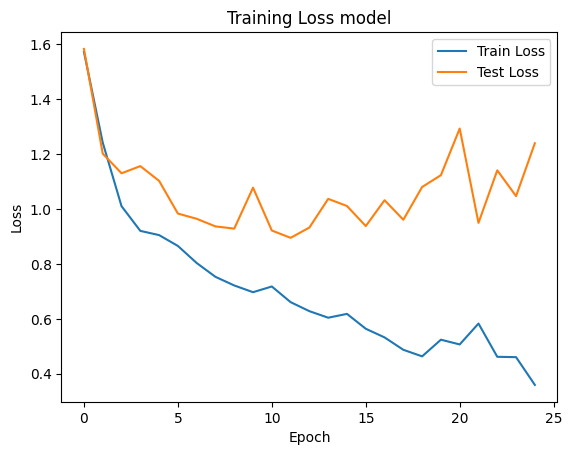

In [37]:
plt.plot(loss_list, label='Train Loss')
plt.plot(my_loss_test, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss model')
plt.savefig('/content/drive/MyDrive/DeepLearning_2023/Final Project/plots/vgg_face_totalretrain_25epochs.png')
plt.show()

### Plotting Confusion Matrix

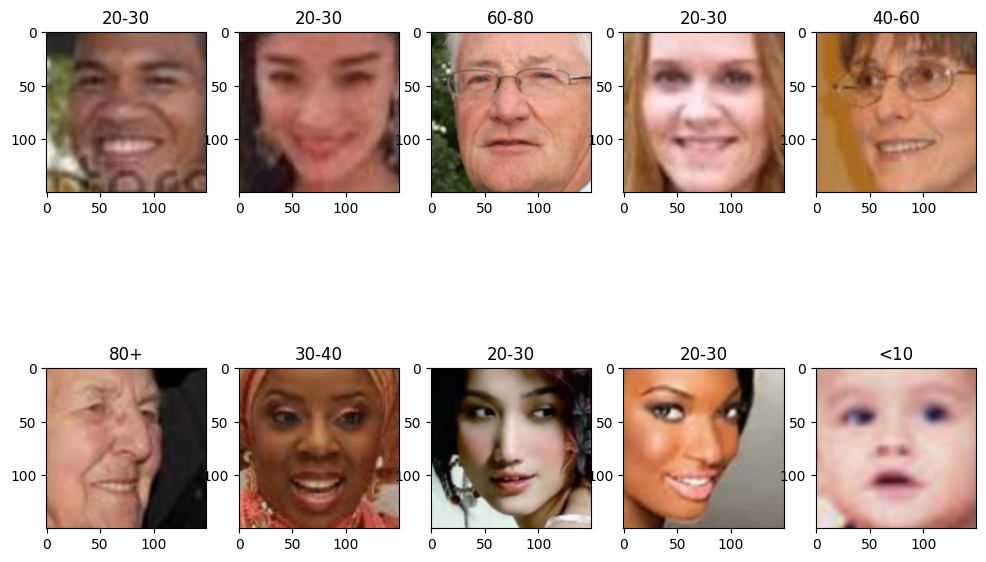

In [41]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

vgg_f = VGG_FACE()

num_classes= 7

vgg_f.fc6 = nn.Linear(512 * 4 * 4, 1024)
vgg_f.fc7 = nn.Linear(1024, 128)
vgg_f.fc8 = nn.Linear(128, num_classes)

vgg_f.load_state_dict(torch.load(results_path + 'vgg_face_totalretrain_25epochs.ckpt'))
vgg_f.cuda()

# Generating predictions from the model above.
vgg_f = vgg_f.to(device)
vgg_f.eval()

predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = vgg_f(images)
        probabilities = torch.softmax(logits, dim=1)
        batch_predictions = torch.argmax(probabilities, dim=1)
        predicted_labels.extend(batch_predictions.tolist())
        # print("IMAGES", images)
        # print("LABELS", labels)
    indx = 0
    f, axarr = plt.subplots(2, 5, figsize=(12, 8))
    for r in range(0, 2):
      for c in range(0, 5):
        img = images[indx].squeeze()
        label = labels[indx]
        axarr[r, c].imshow(transforms.ToPILImage()(img))
        axarr[r, c].set_title(class_labels_map.get(str(label.item())))
        indx+=1



In [42]:
# Generating a confusion matrix based on above predictions.

conf_mat = confusion_matrix(test_labels_list, predicted_labels)
conf_mat

array([[439,  37,   2,   1,   2,   1,   1],
       [ 32, 122,  67,  25,   3,   0,   0],
       [  2,  37, 390, 333,  54,   1,   0],
       [  0,   3,  64, 367, 212,   5,   0],
       [  0,   2,   4, 102, 506,  33,   0],
       [  0,   0,   0,   0, 148, 120,  10],
       [  0,   0,   0,   0,   2,  37,  42]])

In [43]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/MyDrive/DeepLearning_2023/Final Project/dl_nmm/1.1_age_input_output/output/cnn_logs/{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


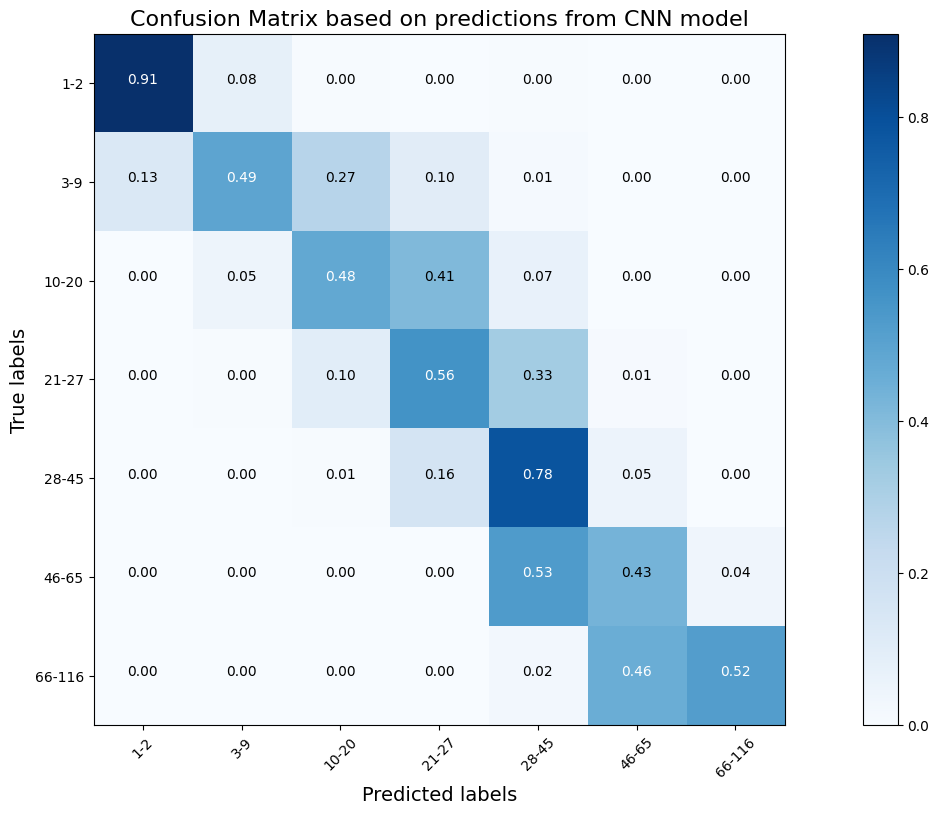

In [44]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )

plt.show()

In [ ]:
-